In [20]:
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset

In [21]:
df = pd.read_csv("sonar.all-data" , header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [22]:
df[60] = df[60].map({"R" : 0 , "M" : 1})

In [23]:
df[60].value_counts()

60
1    111
0     97
Name: count, dtype: int64

In [24]:
df.shape

(208, 61)

In [25]:
from sklearn.model_selection import train_test_split

X = df.drop([60] , axis = 1)
y= df[60]

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

X_train.shape , X_test.shape

((166, 60), (42, 60))

In [26]:
X_train_tensor = torch.tensor(X_train.values , dtype = torch.float32)
X_test_tensor = torch.tensor(X_test.values , dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values , dtype = torch.long)
y_test_tensor = torch.tensor(y_test.values , dtype = torch.long)

In [37]:
train_dataset = TensorDataset(X_train_tensor , y_train_tensor)
test_dataset = TensorDataset(X_test_tensor , y_test_tensor)

train_loader = DataLoader(train_dataset , 16 , shuffle = True)
test_loader = DataLoader(test_dataset , 16 , shuffle = False)

In [38]:
len(train_dataset) , len(test_dataset)

(166, 42)

### Train a Neural Network Without Dropout Regularization

In [39]:
class simpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(60 , 128),
            nn.ReLU(),
            nn.Linear(128 , 64),
            nn.ReLU(),
            nn.Linear(64 , 2)
        )
    def forward(self , x):
        return self.network(x)

In [49]:
# train function
from sklearn.metrics import accuracy_score

def train_model(model ,train_loader , val_loader , optimizer , criterion , epochs = 20):
    train_losses = []
    val_losses =  []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss  = 0.0
        for inputs , labels in train_loader:
            output = model(inputs)
            loss = criterion(output , labels)

            running_loss += loss.item()

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        train_losses.append(running_loss/len(train_loader))


        model.eval()
        val_loss = 0.0
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies

In [52]:
model_without_dropout = simpleNN()
criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_dropout.parameters() , lr = 0.001)

train_losses_no_dropout , val_losses_no_dropout , val_accuracies_no_dropout = train_model(model_without_dropout  ,train_loader , test_loader , optimizer , criterion , epochs = 20)

Epoch 1/20, Train Loss: 0.6968, Val Loss: 0.6622, Val Accuracy: 0.6190
Epoch 2/20, Train Loss: 0.6809, Val Loss: 0.6637, Val Accuracy: 0.8095
Epoch 3/20, Train Loss: 0.6691, Val Loss: 0.6310, Val Accuracy: 0.7857
Epoch 4/20, Train Loss: 0.6462, Val Loss: 0.6107, Val Accuracy: 0.8333
Epoch 5/20, Train Loss: 0.6208, Val Loss: 0.5586, Val Accuracy: 0.8333
Epoch 6/20, Train Loss: 0.5819, Val Loss: 0.5298, Val Accuracy: 0.8095
Epoch 7/20, Train Loss: 0.5383, Val Loss: 0.4313, Val Accuracy: 0.8571
Epoch 8/20, Train Loss: 0.5168, Val Loss: 0.5242, Val Accuracy: 0.6905
Epoch 9/20, Train Loss: 0.4862, Val Loss: 0.3756, Val Accuracy: 0.8571
Epoch 10/20, Train Loss: 0.4680, Val Loss: 0.4654, Val Accuracy: 0.7381
Epoch 11/20, Train Loss: 0.4509, Val Loss: 0.3446, Val Accuracy: 0.8810
Epoch 12/20, Train Loss: 0.4330, Val Loss: 0.3598, Val Accuracy: 0.8571
Epoch 13/20, Train Loss: 0.3887, Val Loss: 0.3390, Val Accuracy: 0.8571
Epoch 14/20, Train Loss: 0.3937, Val Loss: 0.3289, Val Accuracy: 0.8333
E

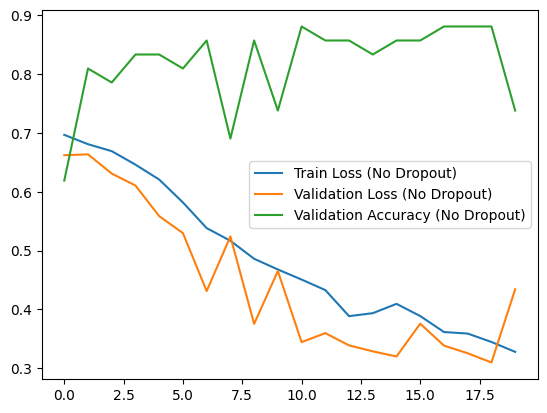

In [53]:
# Plot training and validation loss and accuracy (Without Dropout)
plt.plot(train_losses_no_dropout, label="Train Loss (No Dropout)")
plt.plot(val_losses_no_dropout, label="Validation Loss (No Dropout)")
plt.plot(val_accuracies_no_dropout, label="Validation Accuracy (No Dropout)")
plt.legend()
plt.show()

In [55]:
class simpleNN_with_dropouts(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(60 , 128),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(128 , 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64 , 2)
        )
    def forward(self , x):
        return self.network(x)

In [ ]:
model_with_dropout = simpleNN_with_dropouts()
criterion  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_dropout.parameters() , lr = 0.001)

train_losses_dropout , val_losses_dropout , val_accuracies_no_dropout = train_model(model_without_dropout  ,train_loader , test_loader , optimizer , criterion , epochs = 20)